In this notebook, I'll explore whether we can use Density Estimation Likelihood-Free Inference

In [1]:
import os
import h5py
import numpy as np 
import corner as DFM
# -- galpopfm --
from galpopfm.catalogs import Catalog
from galpopfm import dust_infer as dustInfer

In [2]:
# pydelif
import tensorflow as tf
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import tensorflow_probability as tfp
tfd = tfp.distributions

In [3]:
# -- plotting --
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# Observations

In [4]:
x_obs = dustInfer.sumstat_obs(statistic='2d')

# set up simulator: forward model with EDA

In [5]:
_eagle_sed = dustInfer._read_sed('eagle') 

wlim = (_eagle_sed['wave'] > 1e3) & (_eagle_sed['wave'] < 8e3) 
mlim    = (_eagle_sed['logmstar'] > 9.4) 
zerosfr = (_eagle_sed['logsfr.inst'] == -999)

cuts = mlim

eagle_sed = {} 
eagle_sed['sim']          = 'eagle' 
eagle_sed['logmstar']     = _eagle_sed['logmstar'][cuts].copy()
eagle_sed['logsfr.inst']  = _eagle_sed['logsfr.inst'][cuts].copy() 
eagle_sed['wave']         = _eagle_sed['wave'][wlim].copy()
eagle_sed['sed_neb']    = _eagle_sed['sed_neb'][cuts,:][:,wlim].copy() 
eagle_sed['sed_noneb']    = _eagle_sed['sed_noneb'][cuts,:][:,wlim].copy() 
eagle_sed['sed_onlyneb']  = _eagle_sed['sed_onlyneb'][cuts,:][:,wlim].copy() 

In [10]:
def simulator(theta): 
    zerosfr_obs = dustInfer._observable_zeroSFR(eagle_sed['wave'], eagle_sed['sed_neb'])

    _, numden, _ = dustInfer.sumstat_model(
        theta, 
        sed=eagle_sed,
        dem='slab_noll_mssfr_fixbump', 
        f_downsample=1., 
        statistic='2d', 
        noise=True, 
        extra_data=zerosfr_obs, 
        return_datavector=False)
    return numden[:,80:110].flatten()

In [11]:
x_model = simulator(np.zeros(6)).reshape((8, 30))

(0.0, 30.0)

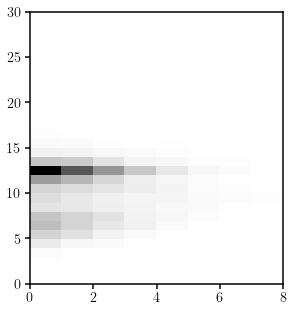

In [13]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(121)
sub.pcolormesh(x_model.T, cmap='Greys')
sub.set_ylim(0, 30)

# set up prior

In [14]:
class Uniform():

    def __init__(self, lower, upper):

        self.lower = lower
        self.upper = upper

    def logpdf(self, x):

        inrange = lambda y: np.prod(y > self.lower)*np.prod(y < self.upper)
        return np.array([inrange(xx)*np.log(np.prod(self.upper-self.lower)) - (1 - inrange(xx))*1e300 for xx in x])
    
    def pdf(self, x):
        
        inrange = lambda y: np.prod(y > self.lower)*np.prod(y < self.upper)
        return np.array([inrange(xx)*np.prod(self.upper-self.lower) for xx in x])

    def draw(self):

        return np.random.uniform(self.lower, self.upper)


In [15]:
lower = np.array([-5., -5., 0., -4., -4., -4.])
upper = np.array([5.0, 5.0, 6., 4.0, 4.0, 4.0]) 

prior = Uniform(lower, upper)

In [15]:
thetas, xs = [], []
for i in range(100): 
    theta_i = prior.draw()
    x_i = simulator(theta_i)

    thetas.append(theta_i)
    xs.append(x_i)
xs = np.array(xs)

# set up compression

In [18]:
# Fiducial parameters
theta_fiducial = np.zeros(6)

In [20]:
_C = np.cov(np.array(xs).T)
#C = np.eye(_C.shape[0]) * np.clip(np.diag(_C), 1e-40, None)
Cinv = np.linalg.inv(C)

In [19]:
x_fids = []
for i in range(10): 
    x_fids.append(simulator(theta_fiducial))
x_fids = np.array(x_fids)

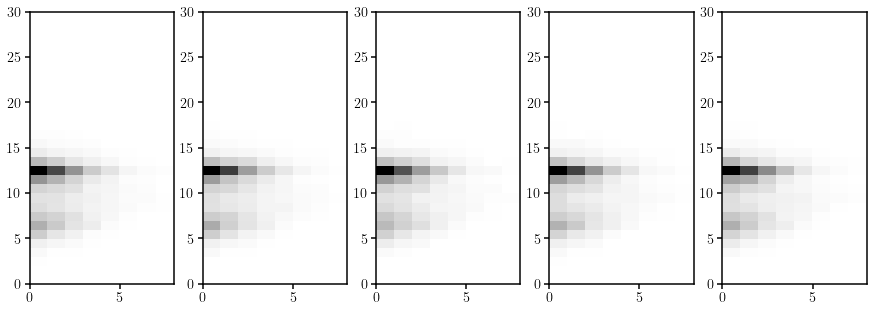

In [40]:
fig = plt.figure(figsize=(15,5))
for i in range(5): 
    sub = fig.add_subplot(1,5,i+1)

    sub.pcolormesh((dfuvnuv * np.sum(x_fids[i].reshape((8, 30, 25)), axis=2)).T, cmap='Greys')
    sub.set_ylim(0, 30)

In [22]:
# calculate the derivatives
step = 0.2 * (upper - lower)

dmudt = [] 
for i in range(len(theta_fiducial)): 
    theta_step = theta_fiducial.copy()
    theta_step[i] += step[i] 
    
    x_step = [] 
    for ii in range(10): 
        x_step.append(simulator(theta_step))
    
    dmudt.append((np.mean(x_step, axis=0) - np.mean(x_fids, axis=0))/step[i])
dmudt = np.array(dmudt)

In [ ]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(121)
sub.pcolormesh(dmudt[0].reshape((8, 30, 25)).T, cmap='Greys')
sub.set_ylim(0, 30)

sub = fig.add_subplot(122)
sub.pcolormesh(x_model_r_fn.T, cmap='Greys')
sub.set_ylim(0, 30)

In [23]:
compressor = score.Gaussian(C.shape[0], theta_fiducial, mu=np.mean(x_fids, axis=0), Cinv=Cinv, dmudt=dmudt)
# Pull out Fisher matrix inverse
compressor.compute_fisher()

In [24]:
Finv = compressor.Finv

In [25]:
def Compressor(X):
    return compressor.scoreMLE(X)

In [26]:
cx_obs = Compressor(x_obs[1][:,80:110,15:40].flatten())

In [27]:
cx_obs

array([-0.03073669,  0.25979977,  0.96228506, -0.17058201,  0.53596764,
       -0.02141214])

In [29]:
cxs = []
for x in xs: 
    cxs.append(Compressor(x))

In [35]:
np.diag(C)[xs[0] > 0]

array([2.00388434e-06, 3.99328245e-07, 3.20356028e-06, 8.78228314e-06,
       1.57923764e-05, 5.71437762e-07, 9.97637299e-09, 6.55980690e-09,
       8.35521238e-08, 1.55450170e-05, 2.41151314e-05, 2.44779878e-05,
       8.88296251e-05, 2.14560351e-08, 2.35574111e-05, 1.67354665e-04,
       5.32574323e-07, 4.25892046e-07, 1.14399445e-05, 1.69923239e-04,
       2.74623583e-07, 7.93675137e-06, 1.58811490e-04, 2.77211631e-06,
       8.94300524e-05, 2.73168809e-05, 4.23881568e-05, 4.95137470e-05,
       1.10970067e-07, 2.01765311e-07, 2.06702249e-07, 6.81733057e-06,
       2.71599238e-05, 9.86663289e-06, 6.38684324e-06, 4.41379340e-06,
       6.39222433e-07, 2.42986181e-07, 8.83182335e-07, 2.07336022e-06,
       1.91565153e-06, 5.72941051e-07, 9.98320612e-08, 5.61305935e-06,
       2.46112339e-05, 2.23518587e-06, 2.65398854e-07, 5.58181485e-07,
       1.53709600e-06, 5.78375099e-06, 3.51967806e-06, 6.96706158e-07,
       1.56547058e-07, 9.62429586e-07, 2.29607591e-05, 2.28666669e-05,
      

In [34]:
for x in xs: 
    print(x[xs[0] > 0][:5])

[0.00123373 0.00041124 0.00041124 0.00041124 0.00123373]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0.00041124 0.00082248 0.00082248 0.00370118 0.00287869]
[0.         0.         0.         0.00287869 0.00328994]
[0.         0.         0.         0.00082248 0.00041124]
[0.00123373 0.         0.00082248 0.00041124 0.00164497]
[0. 0. 0. 0. 0.]
[0.00164497 0.00041124 0.00287869 0.00205621 0.00205621]
[0. 0. 0. 0. 0.]
[0.         0.         0.         0.         0.00205621]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0.         0.         0.         0.00123373 0.        ]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0.00370118 0.00041124 0.00328994 0.00328994 0.00945857]
[0. 0. 0. 0. 0.]
[0.00246745 0.         0.00287869 0.00082248 0.00246745]
[0.         0.         0.00041124 0.00041124 0.00205621]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0.00041124 0.         0.00328994 0.00123373 0.00205621]
[0.         0.         0.00041124 0.         0.00123373]
[0. 0. 0. 0. 0.]
[0.         0.         0.00041124 0.  

In [31]:
cxs

[array([0.0067625 , 0.93536273, 0.01287081, 0.18843184, 0.17326519,
        0.32363235]),
 array([0.0067625 , 0.93536273, 0.01287081, 0.18843184, 0.17326519,
        0.32363235]),
 array([0.0067625 , 0.93536273, 0.01287081, 0.18843184, 0.17326519,
        0.32363235]),
 array([0.0067625 , 0.93536273, 0.01287081, 0.18843184, 0.17326519,
        0.32363235]),
 array([0.0067625 , 0.93536273, 0.01287081, 0.18843184, 0.17326519,
        0.32363235]),
 array([0.0067625 , 0.93536273, 0.01287081, 0.18843184, 0.17326519,
        0.32363235]),
 array([0.0067625 , 0.93536273, 0.01287081, 0.18843184, 0.17326519,
        0.32363235]),
 array([0.0067625 , 0.93536273, 0.01287081, 0.18843184, 0.17326519,
        0.32363235]),
 array([0.0067625 , 0.93536273, 0.01287081, 0.18843184, 0.17326519,
        0.32363235]),
 array([0.0067625 , 0.93536273, 0.01287081, 0.18843184, 0.17326519,
        0.32363235]),
 array([0.0067625 , 0.93536273, 0.01287081, 0.18843184, 0.17326519,
        0.32363235]),
 array([0.

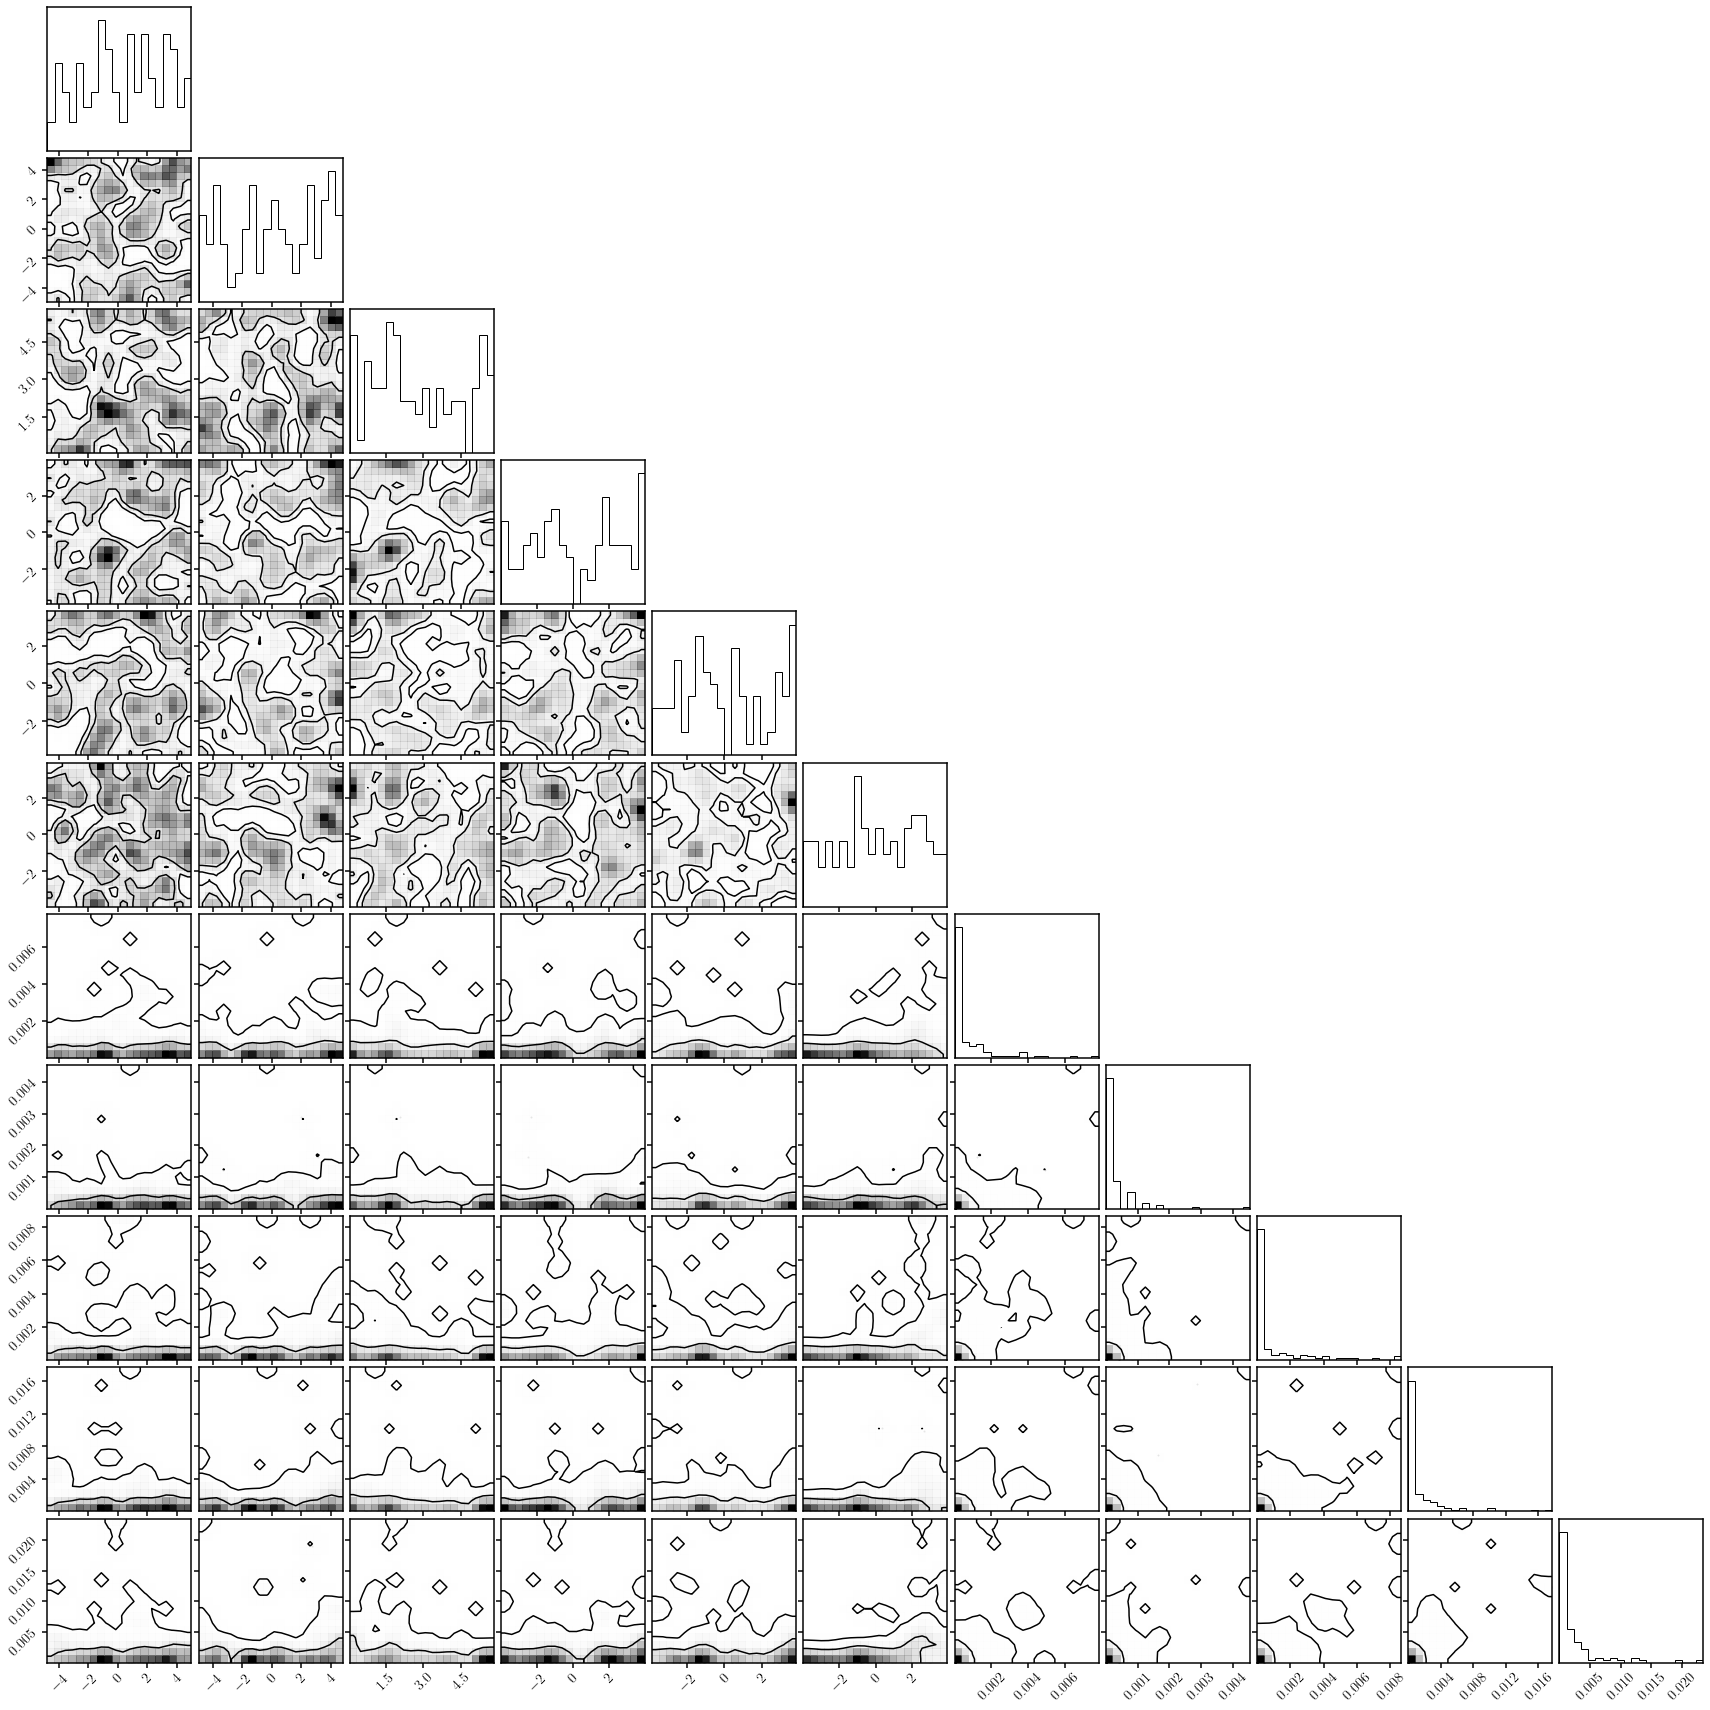

In [38]:
fig = DFM.corner(
    np.concatenate([thetas, xs[:,xs[0] > 0][:,:5]], axis=1),     #range=[(_min, _max) for _min, _max in zip(lower, upper)],
    levels=[0.68, 0.95],
    nbin=20, 
    smooth=True, 
    truths=[None, None, None, None, None, None, cx_obs[0], cx_obs[1], cx_obs[2], cx_obs[3], cx_obs[4], cx_obs[5]]
) 